In [7]:
import numpy as np
from utils import get_data, get_table, get_predictions, other_stats, add_intervals_to_test
from plots import plot_rmse, plot_finish_groups, plot_interval_checks, plot_finish_age_gender
np.random.seed(2025)

size1, size2 = 2500, 40000
save_val = True
train_yr, test_yr = [2021, 2022, 2023], [2024]
train_bos, test_bos = get_data(racename="bos", size_train=size1, size_test=size2, train_lis=train_yr, test_lis=test_yr, save=save_val)
train_nyc, test_nyc = get_data(racename="nyc", size_train=size1, size_test=size2, train_lis=train_yr, test_lis=test_yr, save=save_val)
train_chi, test_chi = get_data(racename="chi", size_train=size1, size_test=size2, train_lis=train_yr, test_lis=test_yr, save=save_val)
data = {"bos": (train_bos, test_bos), "nyc": (train_nyc, test_nyc), "chi": (train_chi, test_chi)}
# test_nyc = pd.read_csv("processed_data/test_nyc.csv")

In [ ]:
#newtimes - 2500
# 68 60 58
# 569 555 542
# 683 668 668

In [8]:
race = "bos"
test = data[race][1]

model_info = [
    ("M1", f"stan_results/model1/params_{race}.csv", ["alpha", "total_pace"]),
    ("M2", f"stan_results/model2/params_{race}.csv", ["alpha", "total_pace", "curr_pace"]),
    ("M3", f"stan_results/model3/params_{race}.csv", ["alpha", "total_pace", "curr_pace", "male", "age"]),
]
mpreds = {name: get_predictions(test, path, feats_lis=feats, full=False) for (name, path, feats) in model_info}
models, baseline = ["M1", "M2", "M3"], "BL"
test2 = get_table(test, mpreds, baseline_name=baseline)
test2

,id,dist,curr_pace,total_pace,finish,age,gender,year,male,malexage,alpha,lvl,BL,M1,M2,M3
22937,88575,5K,2.500000,2.500000,2.286620,29,F,2024,0,0,1,1,-26.250000,-1.298719,-1.167567,-5.620491
9460,75098,5K,3.538570,3.538570,3.349075,38,F,2024,0,0,1,1,-11.244883,0.746633,0.787220,1.032162
2286,67924,5K,4.081633,4.081633,3.962344,44,M,2024,1,44,1,1,-5.187083,3.697293,3.718985,4.028728
25172,90810,5K,2.065262,2.065262,1.923375,36,M,2024,1,36,1,1,-25.119683,12.334662,12.563425,2.671353
17726,83364,5K,3.261579,3.261579,2.793816,23,F,2024,0,0,1,1,-36.100217,-21.866224,-21.811114,-23.923776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190878,79682,40K,3.092146,3.061146,3.061158,64,F,2024,0,0,1,8,0.000860,0.768327,-0.172169,-0.025084
195692,84496,40K,2.331002,2.704713,2.696338,80,M,2024,1,80,1,8,-0.807560,0.077875,1.053157,1.542305
195373,84177,40K,1.963865,2.758430,2.724719,59,F,2024,0,0,1,8,-3.154294,-2.288861,0.881131,0.935170
180076,68880,40K,3.282994,3.889537,3.853073,24,F,2024,0,0,1,8,-1.711092,-1.125991,-0.016384,-0.174781


In [9]:
tbl = plot_rmse(test2, models, baseline, save_name=race, bar=True)
other_stats(test2[[baseline] + models], test2["finish"], save_name=race)
# test2["model1"].argmax()

File saved: analysis/plots/bos_rmse_bar.png
File saved: analysis/tables/bos_rmse.csv
File saved: analysis/tables/bos_rmse2.csv


,BL,M1,M2,M3,pcnt_BL,pcnt_M1,pcnt_M2,pcnt_M3
Overall RMSE,21.910554,15.148938,14.416139,14.351717,-,-,-,-
Overall R-squared,0.789790,0.899513,0.908999,0.909811,-,-,-,-


In [10]:
c_model = "M2"
a = plot_finish_groups(test2, model=c_model, baseline=baseline, num=4, overall=True, save_name=race, palette="inferno")
plot_finish_age_gender(test2, model=c_model, baseline=baseline, num=4, overall=True, save_name=race, palette="crest", grouping="age")

File saved: analysis/plots/bos_rmse_groups.png
File saved: analysis/plots/bos_rmse_gender_age.png


In [11]:
mpreds2 = {name: (42195 / 60) / get_predictions(test, path, feats_lis=feats, full=True) for (name, path, feats) in model_info}
intervals_tbl = add_intervals_to_test(test2, mpreds2, models)
i_check, i_sizes = plot_interval_checks(intervals_tbl, models, save_name=race)

File saved: analysis/plots/bos_intervals
analysis/tables/bos_intsizes.csv
analysis/tables/bos_intcheck.csv


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [43]:
train_bos_full, test_bos_full = get_data(racename="bos", size_train=None, size_test=None, train_lis=train_yr, test_lis=test_yr, save=save_val)
print(train_bos.shape, train_bos_full.shape, test_bos.shape, test_bos_full.shape)

(2500, 11) (525104, 11) (40000, 11) (202096, 11)


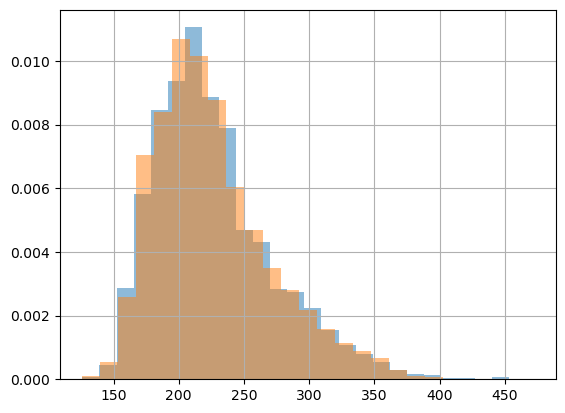

KstestResult(statistic=0.011515573295956621, pvalue=0.8923716239054196, statistic_location=193.9, statistic_sign=1)


In [42]:
((42195 /60) / train_bos["finish"]).hist(alpha=0.5, density=True, bins=25)
((42195 /60) / train_bos_full["finish"]).hist(alpha=0.5, density=True, bins=25)
plt.show()
print(stats.ks_2samp((42195 /60) / train_bos["finish"], (42195 /60) / train_bos_full["finish"]))